In [2]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 9.1 MB/s eta 0:00:00


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
import yfinance as yf

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003983. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-19-2adb72903b25>:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_dates = pd.date_range('2018-01-01', periods=num_days * 24, freq='H')
<ipython-input-19-2adb72903b25>:65: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  four_hourly_data = hourly_data.resample('4H').ohlc()  # 4時間ごとのOHLCデータを取得
<ipython-input-19-2adb72903b25>:71: FutureWarning: 'M' is deprecated and will be removed in a future version, please use

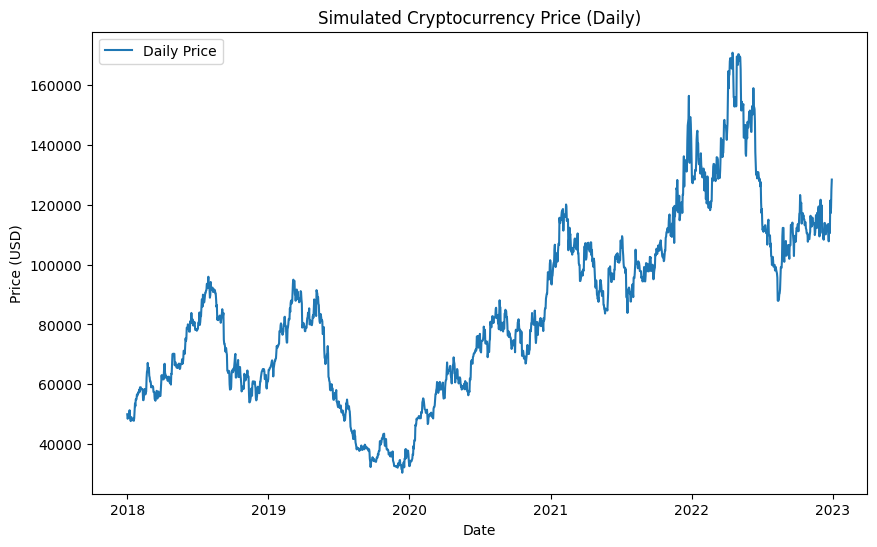

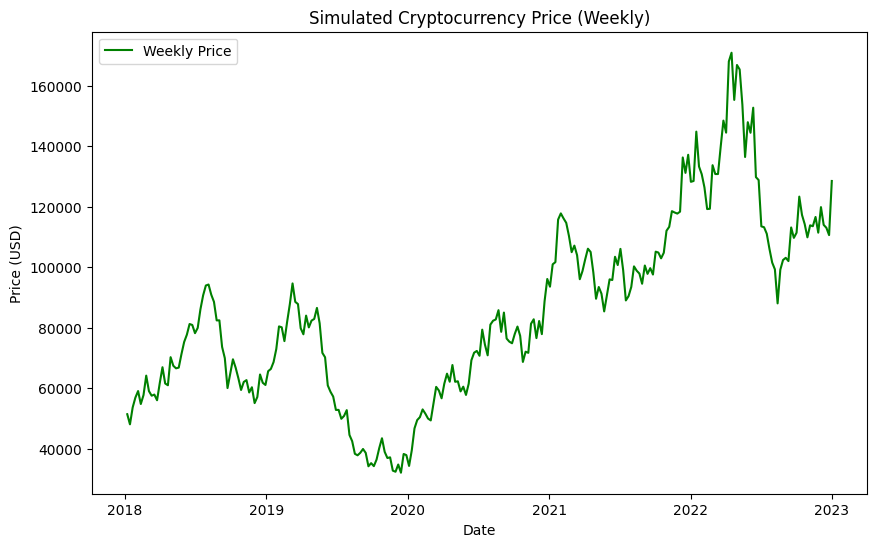

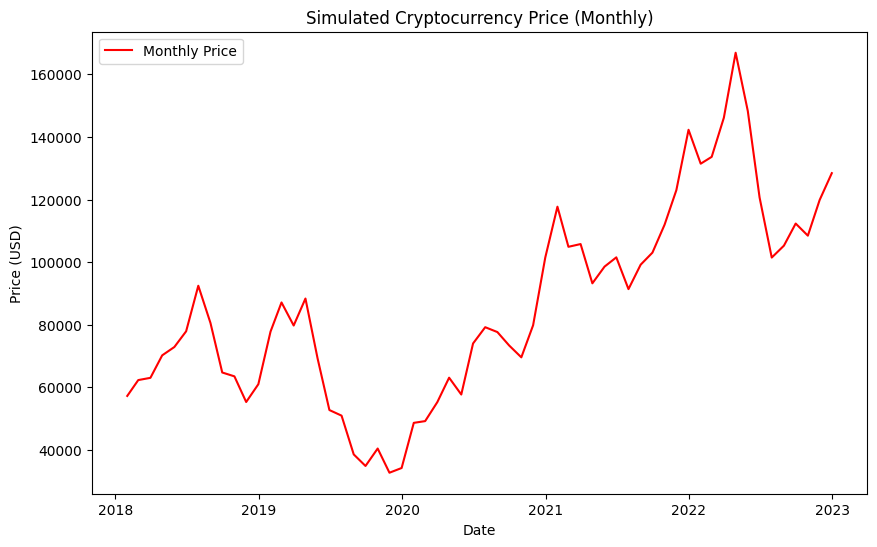

In [19]:
# パラメータ設定
num_days = 365 * 5  # 5年間のシミュレーション
initial_price = 50000  # 初期価格
jump_size_mean = 0.03  # ジャンプの平均サイズ
jump_prob_mean = 0.03  # ジャンプの確率
volatility_noise_scale = 0.015  # ボラティリティノイズのスケール

# 日付（1日単位）
dates = pd.date_range('2018-01-01', periods=num_days, freq='D')

# リターンの生成（仮想通貨のリターンに近い範囲を設定）
returns = np.random.normal(0, 0.02, num_days)  # 平均0、標準偏差0.02のリターン（少し大きめ）

# GARCH(1,1)モデルでボラティリティを推定
returns_df = pd.Series(returns)

# GARCHモデルを適用
model = arch_model(returns_df, vol='Garch', p=1, q=1)
model_fit = model.fit(disp="off")
volatility_estimates = model_fit.conditional_volatility  # 推定されたボラティリティ

# 価格のシミュレーション
price_series = [initial_price]  # 初期価格

# 成長率を削減（価格が過度に上昇しないように調整）
growth_rate = 0.00001  # 小さな成長率（非常に低く設定）

# ジャンプ拡散モデルによるシミュレーション
for i in range(1, len(dates)):
    # ランダムなボラティリティ摂動を追加
    volatility_noise = np.random.normal(0, volatility_noise_scale)
    current_volatility = max(0.0001, volatility_estimates[i-1] + volatility_noise)  # ボラティリティにノイズを加える

    # ボラティリティを考慮したリターン
    daily_return = np.random.normal(0, current_volatility)  # 正規分布によるリターン

    # ランダムジャンプの確率とサイズ
    jump_prob = np.random.normal(jump_prob_mean, 0.015)  # ジャンプ確率にノイズを加える
    jump_prob = np.clip(jump_prob, 0, 1)  # 確率が0から1の間に収まるようにクリッピング
    jump_size = np.random.normal(jump_size_mean, 0.008)  # ジャンプサイズにノイズを加える

    # ジャンプの発生
    if np.random.rand() < jump_prob:
        daily_return += np.random.normal(jump_size, 0.005)  # ジャンプの発生（過度に大きなジャンプを防ぐ）

    # 定常的な成長率を加える
    daily_return += growth_rate
    price_series.append(price_series[-1] * (1 + daily_return))  # 次の日の価格を計算

# DataFrameに変換（1日単位）
df = pd.DataFrame({
    'Date': dates,
    'Price': price_series
})
df.set_index('Date', inplace=True)

# 1時間足、4時間足、週足、月足のデータを生成
# 1時間足（1日24時間、1年間365日と仮定して年間8760時間のデータ）
hourly_dates = pd.date_range('2018-01-01', periods=num_days * 24, freq='H')
hourly_data = pd.DataFrame({
    'Price': np.repeat(price_series, 24)  # 各日について24時間分のデータを繰り返し
}, index=hourly_dates)

# 4時間足
four_hourly_data = hourly_data.resample('4H').ohlc()  # 4時間ごとのOHLCデータを取得

# 週足
weekly_data = df.resample('W').ohlc()  # 週ごとのOHLCデータを取得

# 月足
monthly_data = df.resample('M').ohlc()  # 月ごとのOHLCデータを取得

# 結果のプロット
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Price'], label="Daily Price")
plt.title("Simulated Cryptocurrency Price (Daily)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# 週足データをプロット
plt.figure(figsize=(10, 6))
plt.plot(weekly_data.index, weekly_data['Price']['close'], label="Weekly Price", color='green')
plt.title("Simulated Cryptocurrency Price (Weekly)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# 月足データをプロット
plt.figure(figsize=(10, 6))
plt.plot(monthly_data.index, monthly_data['Price']['close'], label="Monthly Price", color='red')
plt.title("Simulated Cryptocurrency Price (Monthly)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

<ipython-input-10-726951beeb02>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  daily_return = np.random.normal(0, volatility_estimates[i-1] / 100)  # リターン（ボラティリティを考慮）
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


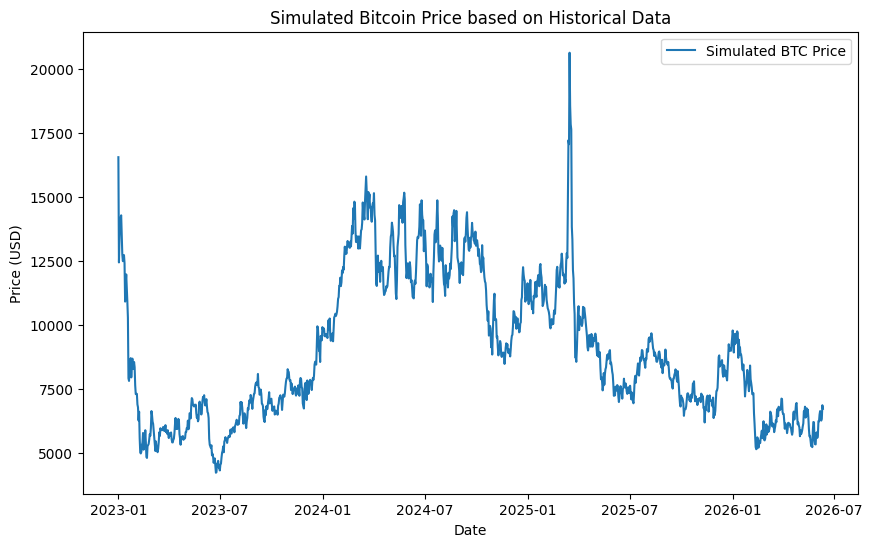

        Date                                    Simulated_Price
0 2023-01-01  Ticker
BTC-USD    16547.496094
Name: 2022-12-3...
1 2023-01-02  Ticker
BTC-USD    12444.024972
Name: 2022-12-3...
2 2023-01-03  Ticker
BTC-USD    13380.416261
Name: 2022-12-3...
3 2023-01-04  Ticker
BTC-USD    14097.345571
Name: 2022-12-3...
4 2023-01-05  Ticker
BTC-USD    14192.532228
Name: 2022-12-3...


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

              precision    recall  f1-score   support

          -1       0.25      0.19      0.22        85
           0       0.49      0.58      0.53       180
           1       0.27      0.24      0.26        91

    accuracy                           0.40       356
   macro avg       0.34      0.34      0.33       356
weighted avg       0.38      0.40      0.39       356



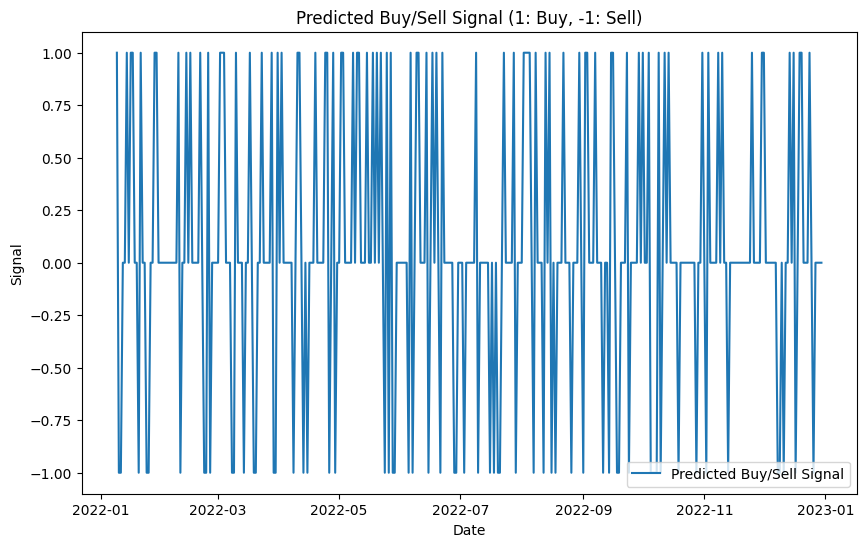

In [21]:
# 価格データを読み込む（dfは仮にシミュレーションした価格データ）
df = pd.DataFrame({
    'Date': pd.date_range('2018-01-01', periods=num_days, freq='D'),
    'Price': price_series
})
df.set_index('Date', inplace=True)

# 移動平均を特徴量として追加（短期と長期の移動平均）
df['SMA_10'] = df['Price'].rolling(window=10).mean()  # 10日移動平均
df['SMA_50'] = df['Price'].rolling(window=50).mean()  # 50日移動平均

# 相対力指数（RSI）の計算
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = compute_rsi(df['Price'])

# ターゲット変数（次の日の価格が前日より1%以上上昇したら買い、下落したら売り、0%±1%なら保持）
df['Target'] = np.where(df['Price'].shift(-1) > df['Price'] * 1.01, 1, 0)  # 1: 買い
df['Target'] = np.where(df['Price'].shift(-1) < df['Price'] * 0.99, -1, df['Target'])  # -1: 売り
df.dropna(inplace=True)  # 欠損値を削除

# 特徴量（移動平均、RSIなど）とターゲット
X = df[['SMA_10', 'SMA_50', 'RSI']]  # 特徴量
y = df['Target']  # ターゲット

# データをトレーニングセットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 特徴量の標準化（スケーリング）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ランダムフォレストを使ったモデル学習
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# テストデータで予測
y_pred = model.predict(X_test_scaled)

# 評価結果
print(classification_report(y_test, y_pred))

# 予測結果をプロット
plt.figure(figsize=(10, 6))
plt.plot(df.index[-len(y_test):], y_pred, label="Predicted Buy/Sell Signal")
plt.title("Predicted Buy/Sell Signal (1: Buy, -1: Sell)")
plt.xlabel("Date")
plt.ylabel("Signal")
plt.legend()
plt.show()

In [22]:
# シミュレーションで使用する仮想データ（価格と売買信号）
# ここでdfは先程作成したデータフレーム
df['Predicted_Signal'] = model.predict(scaler.transform(df[['SMA_10', 'SMA_50', 'RSI']]))  # 売買信号

# 初期資金設定
initial_balance = 10000  # 10000ドルで開始
balance = initial_balance
position = 0  # 0: 現金のみ、1: ポジションを持っている
buy_price = 0  # 購入価格

# 損益計算のためにリストを作成
profit_loss = []

for i in range(1, len(df)):
    # 現在の価格
    current_price = df['Price'].iloc[i]

    # 売買信号に基づく取引
    if df['Predicted_Signal'].iloc[i] == 1 and position == 0:  # 買いシグナルかつ現在現金のみ
        position = balance / current_price  # 購入
        buy_price = current_price  # 購入価格を保存
        balance = 0  # 資金をゼロに設定
        profit_loss.append(0)  # 購入時は損益なし

    elif df['Predicted_Signal'].iloc[i] == -1 and position > 0:  # 売りシグナルかつポジションあり
        balance = position * current_price  # 売却
        position = 0  # ポジションをゼロにする
        profit_loss.append(balance - buy_price * position)  # 損益を計算

    else:
        profit_loss.append(0)  # 売買なしの時は損益なし

# 最終的なバランスと損益
final_balance = balance + position * df['Price'].iloc[-1]  # 最後に売却して残高計算
total_profit_loss = final_balance - initial_balance

# 結果を表示
print(f"初期資金: {initial_balance}ドル")
print(f"最終残高: {final_balance}ドル")
print(f"最終損益: {total_profit_loss}ドル")

初期資金: 10000ドル
最終残高: 1335722386.443128ドル
最終損益: 1335712386.443128ドル


In [ ]:
import requests

# CoinGecko APIでBTCデータを取得
url = 'https://api.coingecko.com/api/v3/coins/bitcoin/market_chart'
params = {
    'vs_currency': 'usd',
    'days': '365',  # 過去1年分のデータ
    'interval': 'daily'
}

response = requests.get(url, params=params)
data = response.json()

# 日付と価格のデータを取得
dates = [entry[0] for entry in data['prices']]  # タイムスタンプ
prices = [entry[1] for entry in data['prices']]  # BTC価格

# DataFrameに変換
df = pd.DataFrame({
    'Date': pd.to_datetime(dates, unit='ms'),
    'Price': prices
})
df.set_index('Date', inplace=True)

# データの確認
print(df.head())


              precision    recall  f1-score   support

          -1       0.26      0.15      0.19       107
           0       0.42      0.61      0.50       145
           1       0.23      0.18      0.20        94

    accuracy                           0.35       346
   macro avg       0.30      0.31      0.30       346
weighted avg       0.32      0.35      0.32       346



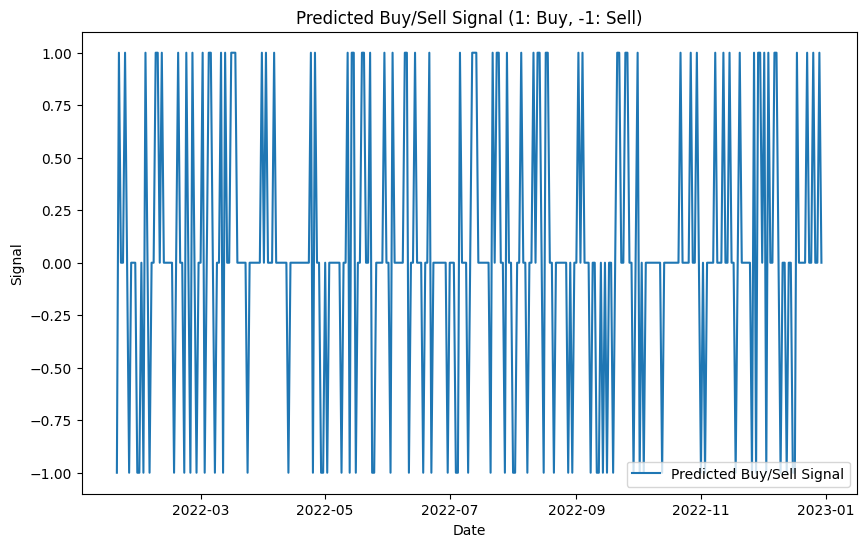

In [23]:
# 移動平均を特徴量として追加（短期と長期の移動平均）
df['SMA_10'] = df['Price'].rolling(window=10).mean()  # 10日移動平均
df['SMA_50'] = df['Price'].rolling(window=50).mean()  # 50日移動平均

# 相対力指数（RSI）の計算
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = compute_rsi(df['Price'])

# ターゲット変数（次の日の価格が前日より1%以上上昇したら買い、下落したら売り、0%±1%なら保持）
df['Target'] = np.where(df['Price'].shift(-1) > df['Price'] * 1.01, 1, 0)  # 1: 買い
df['Target'] = np.where(df['Price'].shift(-1) < df['Price'] * 0.99, -1, df['Target'])  # -1: 売り
df.dropna(inplace=True)  # 欠損値を削除

# 特徴量（移動平均、RSIなど）とターゲット
X = df[['SMA_10', 'SMA_50', 'RSI']]  # 特徴量
y = df['Target']  # ターゲット

# データをトレーニングセットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 特徴量の標準化（スケーリング）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ランダムフォレストを使ったモデル学習
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# テストデータで予測
y_pred = model.predict(X_test_scaled)

# 評価結果
print(classification_report(y_test, y_pred))

# 予測結果をプロット
plt.figure(figsize=(10, 6))
plt.plot(df.index[-len(y_test):], y_pred, label="Predicted Buy/Sell Signal")
plt.title("Predicted Buy/Sell Signal (1: Buy, -1: Sell)")
plt.xlabel("Date")
plt.ylabel("Signal")
plt.legend()
plt.show()

In [25]:
#シミュレーションで使用する仮想データ（価格と売買信号）
# ここでdfは先程作成したデータフレーム
df['Predicted_Signal'] = model.predict(scaler.transform(df[['SMA_10', 'SMA_50', 'RSI']]))  # 売買信号

# 初期資金設定
initial_balance = 10000  # 10000ドルで開始
balance = initial_balance
position = 0  # 0: 現金のみ、1: ポジションを持っている
buy_price = 0  # 購入価格

# 損益計算のためにリストを作成
profit_loss = []

for i in range(1, len(df)):
    # 現在の価格
    current_price = df['Price'].iloc[i]

    # 売買信号に基づく取引
    if df['Predicted_Signal'].iloc[i] == 1 and position == 0:  # 買いシグナルかつ現在現金のみ
        position = balance / current_price  # 購入
        buy_price = current_price  # 購入価格を保存
        balance = 0  # 資金をゼロに設定
        profit_loss.append(0)  # 購入時は損益なし

    elif df['Predicted_Signal'].iloc[i] == -1 and position > 0:  # 売りシグナルかつポジションあり
        balance = position * current_price  # 売却
        position = 0  # ポジションをゼロにする
        profit_loss.append(balance - buy_price * position)  # 損益を計算

    else:
        profit_loss.append(0)  # 売買なしの時は損益なし

# 最終的なバランスと損益
final_balance = balance + position * df['Price'].iloc[-1]  # 最後に売却して残高計算
total_profit_loss = final_balance - initial_balance

# 結果を表示
print(f"初期資金: {initial_balance}ドル")
print(f"最終残高: {final_balance}ドル")
print(f"最終損益: {total_profit_loss}ドル")

初期資金: 10000ドル
最終残高: 850071308.4212109ドル
最終損益: 850061308.4212109ドル
